# General Statistic for Least-Cost-Path QGIS-Plugin

In [1]:
from pandas import read_csv, DataFrame
from geopandas import read_file
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns

In [2]:
stat_data = read_csv('../results/least_cost_paths/execution_time_resolution.csv', sep=';', decimal=',')
stat_data

,Resolution \m,Resolution \px,all touched,run number,execution time \s
0,5,17481 * 11270,True,1.0,2423.87
1,10,8741 * 5635,True,1.0,421.93
2,10,8741 * 5635,True,2.0,419.34
3,50,1749 * 1127,True,1.0,12.69
4,50,1749 * 1127,True,2.0,12.94
5,100,875 * 564,True,1.0,3.02
6,100,875 * 564,True,2.0,3.10
7,5,17481 * 11270,False,1.0,2516.90
8,10,8741 * 5635,False,1.0,412.66
9,10,8741 * 5635,False,2.0,439.19


In [3]:
stat_data.dtypes

Resolution \m          int64
Resolution \px        object
all touched             bool
run number           float64
execution time \s    float64
dtype: object

In [4]:
stat_data.describe()

,Resolution \m,run number,execution time \s
count,14.000000,13.000000,14.000000
mean,46.428571,1.384615,478.217857
std,39.488488,0.506370,864.955779
min,5.000000,1.000000,2.780000
25%,10.000000,1.000000,5.230000
50%,50.000000,1.000000,12.815000
75%,87.500000,2.000000,421.282500
max,100.000000,2.000000,2516.900000


<AxesSubplot: xlabel='Resolution \\m', ylabel='execution time \\s'>

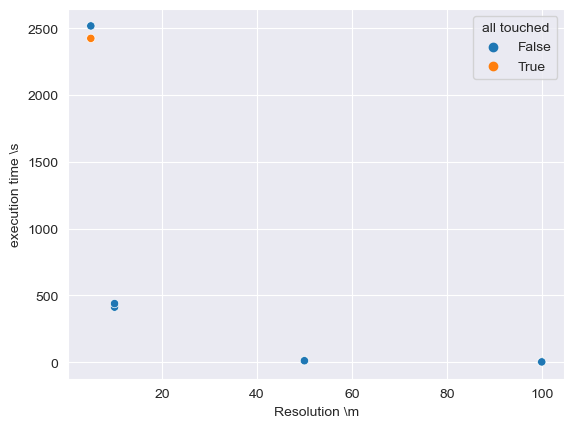

In [5]:
sns.scatterplot(stat_data, x='Resolution \m', y='execution time \s', hue='all touched')

In [6]:
X_inv_log = np.log2(1 / stat_data['Resolution \\m'].values).reshape(-1, 1)
y_log = np.log2(stat_data['execution time \\s'].values)

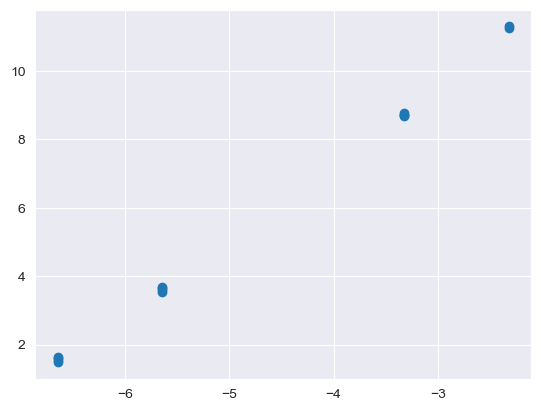

In [7]:
plt.scatter(X_inv_log, y_log)

In [8]:
X_train_inv_log, X_test_inv_log, y_train_log, y_test_log = train_test_split(X_inv_log, y_log, test_size=0.20, random_state=42)

In [20]:
lin_reg = LinearRegression(fit_intercept=True)
lin_reg.fit(X_train_inv_log, y_train_log)

r2_score(y_train_log, lin_reg.predict(X_train_inv_log)), r2_score(y_test_log, lin_reg.predict(X_test_inv_log))

(0.9988329607670805, 0.9972896937377292)

In [23]:
lin_reg.coef_, lin_reg.intercept_

(array([2.19822802]), 16.11593641959958)

## compute standard error

In [25]:
N = len(X_train_inv_log)
p = X_train_inv_log.shape[1] + 1

X_with_intercept = np.empty(shape=(N, p), dtype=np.float)
X_with_intercept[:, 0] = 1
X_with_intercept[:, 1:p] = X_train_inv_log

C:\Users\sebas\AppData\Local\Temp\ipykernel_15248\289182690.py:4: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_with_intercept = np.empty(shape=(N, p), dtype=np.float)


In [29]:
ols = sm.OLS(y_log - lin_reg.intercept_, X_inv_log.flatten())
ols_res = ols.fit()
ols_res.summary()

C:\Users\sebas\anaconda3\envs\CableRoutePlanning\lib\site-packages\scipy\stats\_stats_py.py:1772: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=14
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   1.000
Model:                            OLS   Adj. R-squared (uncentered):              1.000
Method:                 Least Squares   F-statistic:                          9.446e+04
Date:                Mon, 30 Jan 2023   Prob (F-statistic):                    1.73e-26
Time:                        19:30:00   Log-Likelihood:                          8.6269
No. Observations:                  14   AIC:                                     -15.25
Df Residuals:                      13   BIC:                                     -14.61
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             2.1997      0.007    307.339      0.000       2.184       2.215
==============================================================================
Omnibus:                        2.412   Durbin-Watson:                   1.480
Prob(Omnibus):                  0.299   Jarque-Bera (JB):                1.599
Skew:                           0.805   Prob(JB):                        0.450
Kurtosis:                       2.613   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Testing the second order polynomial of the inverse

In [25]:
X_inv = (1 / stat_data['Resolution \\m'].values).reshape(-1, 1)
y_simple = stat_data['execution time \\s'].values
X_train_inv, X_test_inv, y_train_simple, y_test_simple = train_test_split(X_inv, y_simple, test_size=0.20, random_state=42)

model = Pipeline([('poly', PolynomialFeatures(degree=2)),
                   ('linear', LinearRegression()),
                   ])

model.fit(X_train_inv, y_train_simple)

r2_score(y_train_simple, model.predict(X_train_inv)), r2_score(y_test_simple, model.predict(X_test_inv))

(0.9996294244457674, 0.9973275618518096)

## Compare the second order polynomial of the inverse to the squared inverse

In [26]:
X_inv_squared = np.square(1 / stat_data['Resolution \\m'].values).reshape(-1, 1)
y_simple = stat_data['execution time \\s'].values
X_train_inv_sqr, X_test_inv_sqr, y_train_inv_sqr, y_test_inv_sqr = train_test_split(X_inv_squared, y_simple, test_size=0.20, random_state=42)

linear_squared = LinearRegression()
linear_squared.fit(X_train_inv_sqr, y_train_inv_sqr)

r2_score(y_train_inv_sqr, linear_squared.predict(X_train_inv_sqr)), r2_score(y_test_inv_sqr, linear_squared.predict(X_test_inv_sqr))

(0.9838599713963561, 0.9948690355882094)

# Execution time vs Pixel number

In [16]:
stat_data['Resolution_px'] = stat_data['Resolution \\px']
products = [eval(x) for x in stat_data['Resolution_px'].to_list()]
X2 = np.log2(products).reshape(-1, 1)

array([[27.55369999],
       [25.55378252],
       [25.55378252],
       [20.91058637],
       [20.91058637],
       [18.91269056],
       [18.91269056],
       [27.55369999],
       [25.55378252],
       [25.55378252],
       [20.91058637],
       [20.91058637],
       [18.91269056],
       [18.91269056]])

In [17]:
DataFrame({'Log pixel': np.log2(products),'Pixel':stat_data['Resolution \\px'], 'Log y': y_log, 'Original y': stat_data['execution time \\s']})

,Log pixel,Pixel,Log y,Original y
0,27.553700,17481 * 11270,11.243097,2423.87
1,25.553783,8741 * 5635,8.720860,421.93
2,25.553783,8741 * 5635,8.711977,419.34
3,20.910586,1749 * 1127,3.665620,12.69
4,20.910586,1749 * 1127,3.693766,12.94
5,18.912691,875 * 564,1.594549,3.02
6,18.912691,875 * 564,1.632268,3.10
7,27.553700,17481 * 11270,11.297432,2516.90
8,25.553783,8741 * 5635,8.688810,412.66
9,25.553783,8741 * 5635,8.778701,439.19


In [18]:
X2_train, X2_test, y2_train, y2_test = train_test_split(np.log2(products).reshape(-1, 1), y_log, test_size=0.20, random_state=42)

In [19]:
lin_reg2 = LinearRegression()
lin_reg2.fit(X2_train, y2_train)

mean_absolute_error(y2_train, lin_reg.predict(X2_train)), mean_absolute_error(y2_test, lin_reg.predict(X2_test))

(59.63038715650978, 62.49868867536384)

In [20]:
lin_reg2.coef_

array([1.0994909])

# Statistics over the aggregated costs

In [21]:
least_cost_path_5_false = read_file("../results/least_cost_paths/least_cost_path_test_points_res_5_al_false.gpkg")
least_cost_path_5_true = read_file("../results/least_cost_paths/least_cost_path_test_points_res_5_al_true.gpkg")

least_cost_path_10_false = read_file("../results/least_cost_paths/least_cost_path_test_points_res_10_al_false.gpkg")
least_cost_path_10_true = read_file("../results/least_cost_paths/least_cost_path_test_points_res_10_al_true.gpkg")

least_cost_path_50_false = read_file("../results/least_cost_paths/least_cost_path_test_points_res_50_al_false.gpkg")
least_cost_path_50_true = read_file("../results/least_cost_paths/least_cost_path_test_points_res_50_al_true.gpkg")

least_cost_path_100_false = read_file("../results/least_cost_paths/least_cost_path_test_points_res_100_al_false.gpkg")
least_cost_path_100_true = read_file("../results/least_cost_paths/least_cost_path_test_points_res_100_al_true.gpkg")

In [22]:
X = np.log2(np.array([5, 10, 50, 100]).reshape(-1, 1))
y_false = np.log2(np.array([least_cost_path_5_false['total cost'],
           least_cost_path_10_false['total cost'],
           least_cost_path_50_false['total cost'],
           least_cost_path_100_false['total cost'],
           ]))

y_true = np.log2(np.array([least_cost_path_5_true['total cost'],
           least_cost_path_10_true['total cost'],
           least_cost_path_50_true['total cost'],
           least_cost_path_100_true['total cost'],
           ]))

In [23]:
lin_reg_false = LinearRegression()
lin_reg_false.fit(X, y_false)

lin_reg_true = LinearRegression()
lin_reg_true.fit(X, y_true)

r2_score(y_false, lin_reg_false.predict(X)), r2_score(y_true, lin_reg_true.predict(X))

(0.9998469990875714, 0.9933976133506535)

In [24]:
lin_reg_false.coef_[0][0], lin_reg_true.coef_[0][0]

(-1.1305292427570635, -0.8531958731641297)